In [1]:
#installations
!pip install --upgrade opencv-python mediapipe torch torchvision torchsummary seaborn gtts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 24.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 214MB/s]


Epoch [1/20]
Train Loss: 3.0039, Train Accuracy: 0.1375
Test Loss: 2.4678, Test Accuracy: 0.2727
--------------------------------------------------
Epoch [2/20]
Train Loss: 1.9191, Train Accuracy: 0.5375
Test Loss: 1.5892, Test Accuracy: 0.5455
--------------------------------------------------
Epoch [3/20]
Train Loss: 1.1083, Train Accuracy: 0.7708
Test Loss: 1.2194, Test Accuracy: 0.6694
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.5859, Train Accuracy: 0.8917
Test Loss: 0.9045, Test Accuracy: 0.7934
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.3162, Train Accuracy: 0.9521
Test Loss: 0.8106, Test Accuracy: 0.7769
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.2828, Train Accuracy: 0.9479
Test Loss: 0.6998, Test Accuracy: 0.8182
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1977, Train Accuracy: 0.9604
Test Loss: 0.6806, Test Accuracy: 0.8347
---------------

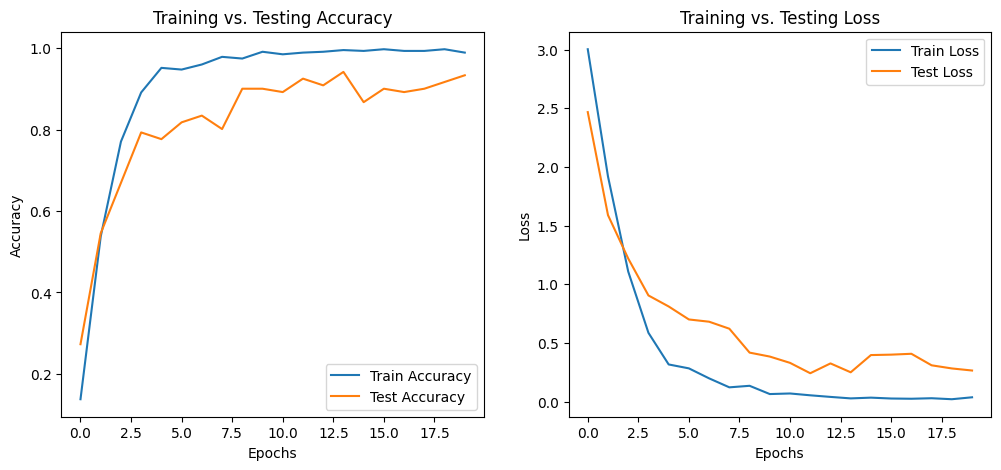

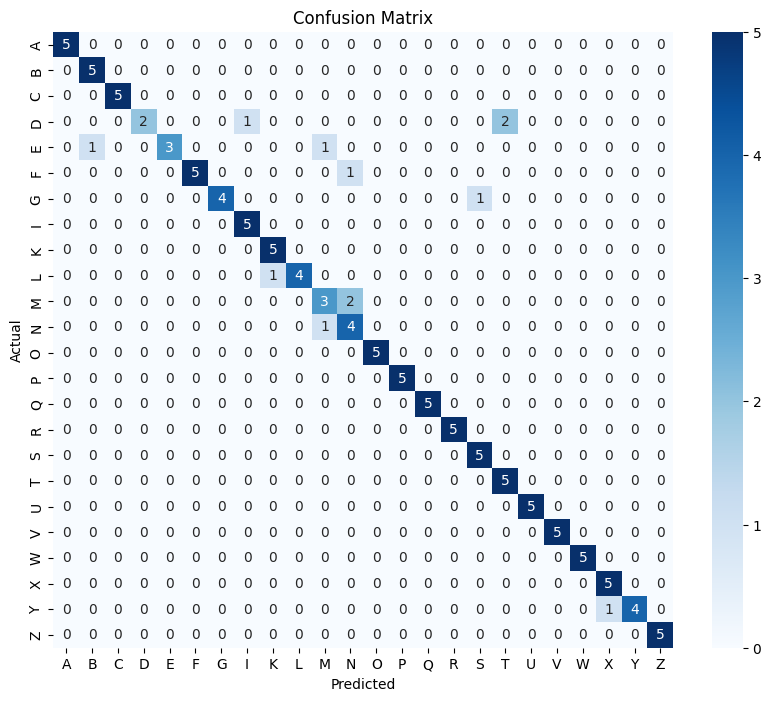

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

# ✅ Dataset path
dataset_path = "/kaggle/input/all-isl-datasets/ISL/ISL_Dataset_3"

# ✅ Class labels (A-Z)
char_to_label = {chr(65 + i): i for i in range(26)}
label_to_char = {v: k for k, v in char_to_label.items()}

# ✅ MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# ✅ Function to extract hand keypoints
def extract_keypoints(image, max_hands=2):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)
    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Custom Dataset Class
class ISLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224, 224))
        keypoints = extract_keypoints(image, max_hands=2)

        if self.transform:
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            image = self.transform(image)

        return image, torch.tensor(keypoints, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ✅ Load Image Paths and Labels
image_paths, labels = [], []
for class_name in sorted(os.listdir(dataset_path)):
    if class_name in char_to_label:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(char_to_label[class_name])

# ✅ Train-Test Split (80-20)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# ✅ Data Transformations (Updated with extra augmentations)
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.GaussianBlur(3),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Create Datasets & Dataloaders
batch_size = 32
train_dataset = ISLDataset(train_paths, train_labels, transform=transform)
test_dataset = ISLDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Define Hybrid Model (ResNet34 + LSTM for Keypoints)
class ResNetLSTM(nn.Module):
    def __init__(self, num_classes=26):
        super(ResNetLSTM, self).__init__()
        # CNN for image feature extraction
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(512, 128)  # Output: 128-dim image feature
        
        # LSTM for keypoint sequence processing
        # The keypoints are reshaped to (batch, sequence_length, input_size) where:
        # sequence_length = 42 (2 hands x 21 keypoints) and input_size = 3 (x, y, z)
        self.lstm = nn.LSTM(input_size=3, hidden_size=128, num_layers=1, batch_first=True)
        # Fully connected layer to reduce LSTM output to 64 dimensions
        self.fc_key = nn.Linear(128, 64)
        
        # Final classifier combining image and keypoint features
        self.final_fc = nn.Linear(128 + 64, num_classes)

    def forward(self, image, keypoints):
        # Process image with CNN (ResNet34)
        img_features = self.resnet(image)  # shape: (batch, 128)
        
        # Reshape keypoints: original shape (batch, 126) --> (batch, 42, 3)
        batch_size = keypoints.size(0)
        keypoints_seq = keypoints.view(batch_size, 42, 3)
        
        # Process keypoints with LSTM
        lstm_out, (hn, cn) = self.lstm(keypoints_seq)  # hn shape: (1, batch, 128)
        keypoint_features = self.fc_key(hn[-1])  # shape: (batch, 64)
        
        # Concatenate features and classify
        combined = torch.cat((img_features, keypoint_features), dim=1)  # shape: (batch, 128+64)
        return self.final_fc(combined)

# ✅ Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetLSTM(num_classes=26).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# ✅ Training Loop with Loss Calculation and Gradient Clipping
num_epochs = 20
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    train_correct, train_total, running_train_loss = 0, 0, 0.0
    
    for images, keypoints, labels in train_loader:
        images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        running_train_loss += loss.item()

    train_loss_epoch = running_train_loss / len(train_loader)
    train_acc_epoch = train_correct / train_total
    train_loss_list.append(train_loss_epoch)
    train_acc_list.append(train_acc_epoch)

    # ✅ Testing Loop
    model.eval()
    test_correct, test_total, running_test_loss = 0, 0, 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, keypoints, labels in test_loader:
            images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss_epoch = running_test_loss / len(test_loader)
    test_acc_epoch = test_correct / test_total
    test_loss_list.append(test_loss_epoch)
    test_acc_list.append(test_acc_epoch)

    # ✅ Print Losses and Accuracies for Each Epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_acc_epoch:.4f}")
    print(f"Test Loss: {test_loss_epoch:.4f}, Test Accuracy: {test_acc_epoch:.4f}")
    print("-" * 50)

    scheduler.step()

# ✅ Save the trained model
torch.save(model.state_dict(), "ResNetLSTM_ISL_3.pth")
print("Updated Model saved as 'ResNetLSTM_ISL_3.pth'.")

# ✅ Plot Training Progress for Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Testing Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Testing Loss")
plt.show()

# ✅ Confusion Matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, keypoints, labels in test_loader:
        images, keypoints, labels = images.to(device), keypoints.to(device), labels.to(device)
        outputs = model(images, keypoints)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(set(all_labels))
class_names = [label_to_char[i] for i in unique_labels]

cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


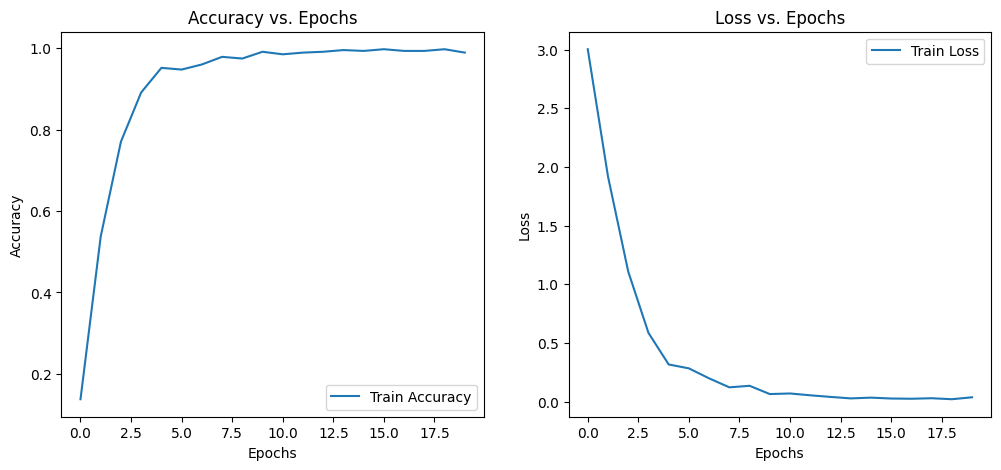

In [5]:
# ✅ Plot Training Progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epochs")
plt.show()

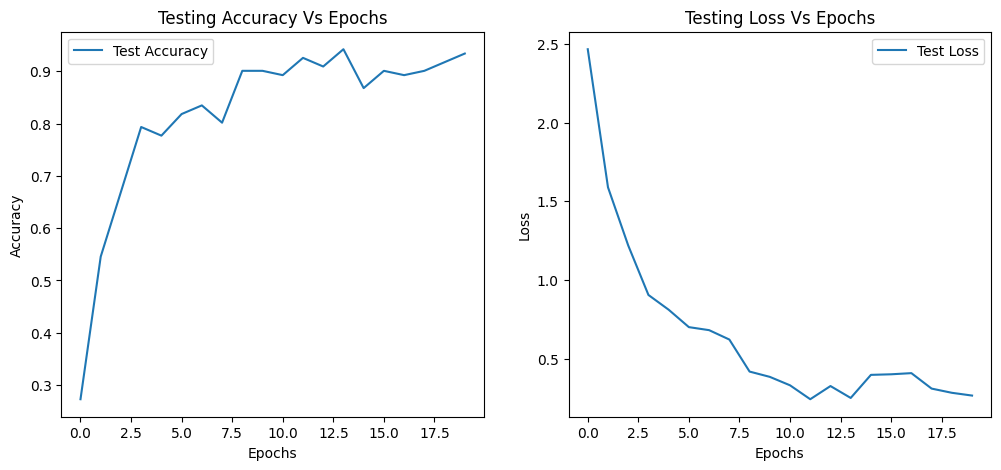

In [6]:
# ✅ Plot Training Progress for Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Testing Accuracy Vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Testing Loss Vs Epochs")
plt.show()

In [3]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate overall accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {acc:.4f}")

# Generate and print the classification report
target_names = [label_to_char[i] for i in sorted(set(all_labels))]
report = classification_report(all_labels, all_preds, target_names=target_names)
print("Classification Report:")
print(report)


Overall Accuracy: 0.9008
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         5
           B       0.83      1.00      0.91         5
           C       1.00      1.00      1.00         5
           D       1.00      0.40      0.57         5
           E       1.00      0.60      0.75         5
           F       1.00      0.83      0.91         6
           G       1.00      0.80      0.89         5
           I       0.83      1.00      0.91         5
           K       0.83      1.00      0.91         5
           L       1.00      0.80      0.89         5
           M       0.60      0.60      0.60         5
           N       0.57      0.80      0.67         5
           O       1.00      1.00      1.00         5
           P       1.00      1.00      1.00         5
           Q       1.00      1.00      1.00         5
           R       1.00      1.00      1.00         5
           S       0.83      1.00

In [4]:
import os
import cv2
import torch
import numpy as np
import mediapipe as mp
import torchvision.transforms as transforms
from PIL import Image
from gtts import gTTS
import IPython.display as ipd  # For playing audio in Kaggle Notebook

# ✅ Define Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/working/ResNetLSTM_ISL_3.pth"  # Updated model path for new dataset

# ✅ Define the Hybrid Model (ResNet + LSTM for Keypoints)
import torch.nn as nn
import torchvision.models as models

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes=26):
        super(ResNetLSTM, self).__init__()
        # CNN for image feature extraction using ResNet34
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(512, 128)  # Output: 128-dim image features
        
        # LSTM for keypoint sequence processing:
        # We have 2 hands x 21 keypoints x 3 coordinates = 126 numbers.
        # Reshape to a sequence of 42 steps with 3 features each.
        self.lstm = nn.LSTM(input_size=3, hidden_size=128, num_layers=1, batch_first=True)
        self.fc_key = nn.Linear(128, 64)  # Reduce LSTM output to 64-dim
        
        # Final classifier combining CNN and LSTM features
        self.final_fc = nn.Linear(128 + 64, num_classes)

    def forward(self, image, keypoints):
        # Extract image features using ResNet34
        img_features = self.resnet(image)  # shape: (batch, 128)
        
        # Reshape keypoints: from (batch, 126) -> (batch, 42, 3)
        batch_size = keypoints.size(0)
        keypoints_seq = keypoints.view(batch_size, 42, 3)
        
        # Process keypoints with LSTM
        lstm_out, (hn, cn) = self.lstm(keypoints_seq)  # hn shape: (num_layers, batch, hidden_size)
        keypoint_features = self.fc_key(hn[-1])  # Use the last hidden state, shape: (batch, 64)
        
        # Concatenate CNN and LSTM features and classify
        combined = torch.cat((img_features, keypoint_features), dim=1)  # shape: (batch, 128+64)
        return self.final_fc(combined)

# ✅ Load Model
model = ResNetLSTM(num_classes=26).to(device)  # Adjusted for A-Z classes
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Character Mappings
label_to_char = {i: chr(65 + i) for i in range(26)}  # A-Z mapping

# ✅ Initialize MediaPipe
mp_hands = mp.solutions.hands

def extract_keypoints(image, max_hands=2):
    """Extracts keypoints from the image using MediaPipe Hands."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = np.zeros(max_hands * 21 * 3)  # Pre-allocate keypoints array
    with mp_hands.Hands(static_image_mode=False, max_num_hands=max_hands, min_detection_confidence=0.7) as hands:
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for h, hand_landmarks in enumerate(results.multi_hand_landmarks[:max_hands]):
                for i, landmark in enumerate(hand_landmarks.landmark):
                    keypoints[h * 21 * 3 + i * 3] = landmark.x
                    keypoints[h * 21 * 3 + i * 3 + 1] = landmark.y
                    keypoints[h * 21 * 3 + i * 3 + 2] = landmark.z
    return keypoints

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Get Image Paths from User Input
dataset_path = "/kaggle/input/all-isl-datasets/ISL/ISL_Dataset_3/"
input_images = [
    os.path.join(dataset_path, "A", "A (1).jpg"),
    os.path.join(dataset_path, "B", "B (1).jpg"),
    os.path.join(dataset_path, "C", "C (1).jpg")
]

# ✅ Perform Prediction
predictions = []
for img_path in input_images:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not read image at {img_path}")
        continue

    # Convert BGR to RGB and apply transforms
    image_rgb = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Add batch dimension

    # Extract keypoints and convert to tensor
    keypoints = extract_keypoints(image, max_hands=2)
    keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor, keypoints_tensor)
        predicted_label = torch.argmax(output, dim=1).item()
        predicted_char = label_to_char[predicted_label]
        predictions.append(predicted_char)

    print(f"Predicted Character for {os.path.basename(img_path)}: {predicted_char}")

# ✅ Convert Predicted Text to Speech
if predictions:
    predicted_text = "".join(predictions)
    print(f"\nFinal Predicted Text: {predicted_text}")
    tts = gTTS(predicted_text)
    tts.save("predicted_audio.mp3")
    ipd.display(ipd.Audio("predicted_audio.mp3"))  # Play in Kaggle Notebook
else:
    print("No predictions were made.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Character for A (1).jpg: A
Predicted Character for B (1).jpg: B
Predicted Character for C (1).jpg: C

Final Predicted Text: ABC
